In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [79]:
max_fake = 1000
t_all_new = np.zeros((max_fake, 7, 336))
t_all_new[:52,:,:] = t_all.copy()

np.random.seed(0)
for i in range(52, max_fake):
    home_agg = np.zeros((1, 336))
    for appliance in range(1, 7):
        t_home_chosen = np.random.choice(list(range(30)))
        t_all_new[i, appliance, :] = t_all.copy()[t_home_chosen, appliance, :]
        home_agg += t_all.copy()[t_home_chosen, appliance, :]
    t_all_new[i, 0, :] = home_agg
        

In [80]:
train_agg = t_all_new[52:, 0, :].reshape((max_fake-52)*14, 24)
train_appliance = t_all[:30, 1:, :].reshape(30*14, 6*24)

train_hvac = t_all_new[52:, 1, :].reshape((max_fake-52)*14, 24)
train_fridge = t_all_new[52:, 2, :].reshape((max_fake-52)*14, 24)
train_mw = t_all_new[52:, 3, :].reshape((max_fake-52)*14, 24)
train_dw = t_all_new[52:, 4, :].reshape((max_fake-52)*14, 24)
train_wm = t_all_new[52:, 5, :].reshape((max_fake-52)*14, 24)
train_oven = t_all_new[52:, 6, :].reshape((max_fake-52)*14, 24)








train_agg_new = train_hvac + train_fridge





test_hvac = t_all_new[30:52, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:52, 2, :].reshape(22*14, 24)
test_mw = t_all[30:52, 3, :].reshape(22*14, 24)
test_dw = t_all[30:52, 4, :].reshape(22*14, 24)
test_wm = t_all[30:52, 5, :].reshape(22*14, 24)
test_oven = t_all[30:52, 6, :].reshape(22*14, 24)
test_appliance = t_all[30:52, 1:, :].reshape(22*14, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*14, 24)
test_agg_new = test_hvac + test_fridge




train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all_new[52:, appliance_num+1, :].reshape((max_fake-52)*14, 24)
    test_appliance[appliance] = t_all[30:52, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:52, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:52, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [81]:
train_hvac.shape

(13272, 24)

In [82]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

In [93]:
pred_appliance = {}
num_iterations_dictionary = {'hvac':900,'fridge':400,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[1:]:
    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    from keras import regularizers
    agg_input = keras.layers.Input(shape=[24],name='Aggregate')
    appliance_dense_1 = keras.layers.Dense(units=20,name='Appliance-layer-1',activation='relu')(agg_input)
    #appliance_bn = keras.layers.BatchNormalization()(appliance_dense_1)
    dropout = keras.layers.Dropout(rate=0.1,name='Droput-Appliance')(appliance_dense_1)




    out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
    out = Minimum(name='Clip-to-agg')([out, agg_input])


    model = keras.Model(agg_input, out)
    model.compile('adam','mean_absolute_error')
    model.fit(train_agg, train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg)



hvac
********************
Train on 11944 samples, validate on 1328 samples
Epoch 1/900
11944/11944 [==============================] - 1s 98us/step - loss: 241.3034 - val_loss: 131.7954
Epoch 2/900
11944/11944 [==============================] - 0s 40us/step - loss: 129.5200 - val_loss: 131.6489
Epoch 3/900
11944/11944 [==============================] - 1s 49us/step - loss: 129.0373 - val_loss: 131.6791
Epoch 4/900
11944/11944 [==============================] - 0s 38us/step - loss: 128.8662 - val_loss: 131.6417
Epoch 5/900
11944/11944 [==============================] - 0s 33us/step - loss: 128.8787 - val_loss: 131.6755
Epoch 6/900
11944/11944 [==============================] - 0s 35us/step - loss: 128.8457 - val_loss: 131.6756
Epoch 7/900
11944/11944 [==============================] - 0s 33us/step - loss: 128.8496 - val_loss: 131.6500
Epoch 8/900
11944/11944 [==============================] - 0s 34us/step - loss: 128.7699 - val_loss: 131.5964
Epoch 9/900
11944/11944 [====================

11944/11944 [==============================] - 0s 39us/step - loss: 116.2077 - val_loss: 115.5994
Epoch 75/900
11944/11944 [==============================] - 0s 34us/step - loss: 116.1997 - val_loss: 115.5648
Epoch 76/900
11944/11944 [==============================] - 0s 40us/step - loss: 115.9720 - val_loss: 114.7041
Epoch 77/900
11944/11944 [==============================] - 1s 47us/step - loss: 116.1805 - val_loss: 114.9477
Epoch 78/900
11944/11944 [==============================] - 1s 48us/step - loss: 116.0154 - val_loss: 114.9790
Epoch 79/900
11944/11944 [==============================] - 0s 40us/step - loss: 115.8932 - val_loss: 114.7419
Epoch 80/900
11944/11944 [==============================] - 0s 38us/step - loss: 115.6681 - val_loss: 114.5064
Epoch 81/900
11944/11944 [==============================] - 1s 42us/step - loss: 115.8580 - val_loss: 114.3362
Epoch 82/900
11944/11944 [==============================] - 0s 36us/step - loss: 115.5988 - val_loss: 114.5099
Epoch 83/900
1

11944/11944 [==============================] - 0s 35us/step - loss: 114.1356 - val_loss: 114.1503
Epoch 148/900
11944/11944 [==============================] - 1s 51us/step - loss: 114.2476 - val_loss: 112.1323
Epoch 149/900
11944/11944 [==============================] - 0s 39us/step - loss: 114.3413 - val_loss: 112.5976
Epoch 150/900
11944/11944 [==============================] - 0s 35us/step - loss: 114.1454 - val_loss: 111.2872
Epoch 151/900
11944/11944 [==============================] - 0s 33us/step - loss: 114.1726 - val_loss: 111.5700
Epoch 152/900
11944/11944 [==============================] - 0s 36us/step - loss: 114.2986 - val_loss: 111.3714
Epoch 153/900
11944/11944 [==============================] - 0s 33us/step - loss: 114.0246 - val_loss: 112.5040
Epoch 154/900
11944/11944 [==============================] - 0s 34us/step - loss: 114.1278 - val_loss: 112.0757
Epoch 155/900
11944/11944 [==============================] - 0s 35us/step - loss: 114.1387 - val_loss: 111.3835
Epoch 

11944/11944 [==============================] - 0s 33us/step - loss: 113.1097 - val_loss: 111.4526
Epoch 221/900
11944/11944 [==============================] - 0s 34us/step - loss: 113.1969 - val_loss: 109.7197
Epoch 222/900
11944/11944 [==============================] - 0s 33us/step - loss: 113.1749 - val_loss: 112.9476
Epoch 223/900
11944/11944 [==============================] - 0s 33us/step - loss: 113.0012 - val_loss: 111.7181
Epoch 224/900
11944/11944 [==============================] - 0s 34us/step - loss: 113.1216 - val_loss: 110.4388
Epoch 225/900
11944/11944 [==============================] - 0s 34us/step - loss: 113.2199 - val_loss: 109.6194
Epoch 226/900
11944/11944 [==============================] - 0s 36us/step - loss: 113.1282 - val_loss: 110.3122
Epoch 227/900
11944/11944 [==============================] - 0s 34us/step - loss: 112.7364 - val_loss: 109.0235
Epoch 228/900
11944/11944 [==============================] - 0s 35us/step - loss: 113.0064 - val_loss: 111.7457
Epoch 

11944/11944 [==============================] - 0s 41us/step - loss: 111.8087 - val_loss: 109.3279
Epoch 294/900
11944/11944 [==============================] - 1s 49us/step - loss: 111.8707 - val_loss: 108.4166
Epoch 295/900
11944/11944 [==============================] - 1s 43us/step - loss: 112.0677 - val_loss: 108.0083
Epoch 296/900
11944/11944 [==============================] - 0s 38us/step - loss: 111.9568 - val_loss: 108.0721
Epoch 297/900
11944/11944 [==============================] - 0s 37us/step - loss: 111.8092 - val_loss: 108.3763
Epoch 298/900
11944/11944 [==============================] - 1s 44us/step - loss: 111.8983 - val_loss: 108.7830
Epoch 299/900
11944/11944 [==============================] - 0s 37us/step - loss: 111.9294 - val_loss: 108.4833
Epoch 300/900
11944/11944 [==============================] - 0s 35us/step - loss: 111.9105 - val_loss: 109.1099
Epoch 301/900
11944/11944 [==============================] - 0s 34us/step - loss: 112.1296 - val_loss: 110.2822
Epoch 

11944/11944 [==============================] - 0s 35us/step - loss: 111.5571 - val_loss: 108.7180
Epoch 367/900
11944/11944 [==============================] - 0s 34us/step - loss: 111.5046 - val_loss: 107.5131
Epoch 368/900
11944/11944 [==============================] - 0s 35us/step - loss: 111.2294 - val_loss: 107.4175
Epoch 369/900
11944/11944 [==============================] - 0s 35us/step - loss: 111.3170 - val_loss: 107.2849
Epoch 370/900
11944/11944 [==============================] - 0s 34us/step - loss: 111.1441 - val_loss: 108.0073
Epoch 371/900
11944/11944 [==============================] - 0s 36us/step - loss: 111.0449 - val_loss: 106.8836
Epoch 372/900
11944/11944 [==============================] - 1s 43us/step - loss: 110.8756 - val_loss: 106.6726
Epoch 373/900
11944/11944 [==============================] - 0s 39us/step - loss: 110.6426 - val_loss: 109.8735
Epoch 374/900
11944/11944 [==============================] - 0s 39us/step - loss: 110.9568 - val_loss: 106.0474
Epoch 

11944/11944 [==============================] - 0s 36us/step - loss: 110.4861 - val_loss: 108.3614
Epoch 440/900
11944/11944 [==============================] - 0s 39us/step - loss: 110.0759 - val_loss: 109.1151
Epoch 441/900
11944/11944 [==============================] - 0s 40us/step - loss: 110.3682 - val_loss: 108.1917
Epoch 442/900
11944/11944 [==============================] - 0s 36us/step - loss: 110.3969 - val_loss: 106.5702
Epoch 443/900
11944/11944 [==============================] - 0s 35us/step - loss: 110.5376 - val_loss: 111.3606
Epoch 444/900
11944/11944 [==============================] - 0s 37us/step - loss: 110.3425 - val_loss: 105.3670
Epoch 445/900
11944/11944 [==============================] - 0s 34us/step - loss: 110.2858 - val_loss: 105.0676
Epoch 446/900
11944/11944 [==============================] - 0s 35us/step - loss: 110.2674 - val_loss: 107.2883
Epoch 447/900
11944/11944 [==============================] - 0s 34us/step - loss: 110.6089 - val_loss: 106.3150
Epoch 

11944/11944 [==============================] - 0s 35us/step - loss: 109.5605 - val_loss: 104.8689
Epoch 513/900
11944/11944 [==============================] - 0s 37us/step - loss: 110.0048 - val_loss: 107.6240
Epoch 514/900
11944/11944 [==============================] - 0s 33us/step - loss: 109.8354 - val_loss: 104.4346
Epoch 515/900
11944/11944 [==============================] - 0s 33us/step - loss: 109.8050 - val_loss: 104.0461
Epoch 516/900
11944/11944 [==============================] - 1s 43us/step - loss: 109.6639 - val_loss: 104.2316
Epoch 517/900
11944/11944 [==============================] - 0s 39us/step - loss: 110.0767 - val_loss: 107.0638
Epoch 518/900
11944/11944 [==============================] - 0s 35us/step - loss: 109.8573 - val_loss: 107.0364
Epoch 519/900
11944/11944 [==============================] - 0s 33us/step - loss: 109.7867 - val_loss: 105.5549
Epoch 520/900
11944/11944 [==============================] - 0s 36us/step - loss: 110.1031 - val_loss: 105.1897
Epoch 

11944/11944 [==============================] - 0s 35us/step - loss: 109.7703 - val_loss: 107.1259
Epoch 586/900
11944/11944 [==============================] - 0s 35us/step - loss: 109.5761 - val_loss: 104.8015
Epoch 587/900
11944/11944 [==============================] - 0s 34us/step - loss: 109.5624 - val_loss: 105.0260
Epoch 588/900
11944/11944 [==============================] - 0s 34us/step - loss: 109.9537 - val_loss: 105.6972
Epoch 589/900
11944/11944 [==============================] - 0s 36us/step - loss: 109.6793 - val_loss: 105.2489
Epoch 590/900
11944/11944 [==============================] - 0s 36us/step - loss: 109.9036 - val_loss: 107.4621
Epoch 591/900
11944/11944 [==============================] - 0s 37us/step - loss: 109.5668 - val_loss: 106.9261
Epoch 592/900
11944/11944 [==============================] - 0s 35us/step - loss: 109.8875 - val_loss: 104.1864
Epoch 593/900
11944/11944 [==============================] - 0s 36us/step - loss: 109.5598 - val_loss: 105.5902
Epoch 

11944/11944 [==============================] - 0s 41us/step - loss: 109.6785 - val_loss: 108.0320
Epoch 659/900
11944/11944 [==============================] - 0s 36us/step - loss: 108.9629 - val_loss: 103.4441
Epoch 660/900
11944/11944 [==============================] - 1s 45us/step - loss: 109.3696 - val_loss: 104.2979
Epoch 661/900
11944/11944 [==============================] - 0s 39us/step - loss: 109.3894 - val_loss: 103.6693
Epoch 662/900
11944/11944 [==============================] - 0s 42us/step - loss: 109.1411 - val_loss: 102.8769
Epoch 663/900
11944/11944 [==============================] - 1s 43us/step - loss: 109.4485 - val_loss: 105.2306
Epoch 664/900
11944/11944 [==============================] - 1s 47us/step - loss: 109.4546 - val_loss: 106.1033
Epoch 665/900
11944/11944 [==============================] - 1s 45us/step - loss: 109.1622 - val_loss: 103.3554
Epoch 666/900
11944/11944 [==============================] - 0s 36us/step - loss: 109.7486 - val_loss: 107.7140
Epoch 

11944/11944 [==============================] - 0s 34us/step - loss: 109.2564 - val_loss: 103.1450
Epoch 732/900
11944/11944 [==============================] - 1s 55us/step - loss: 109.3811 - val_loss: 104.1867
Epoch 733/900
11944/11944 [==============================] - 1s 51us/step - loss: 109.3046 - val_loss: 105.8760
Epoch 734/900
11944/11944 [==============================] - 0s 41us/step - loss: 109.3329 - val_loss: 103.6973
Epoch 735/900
11944/11944 [==============================] - 0s 41us/step - loss: 109.3455 - val_loss: 104.6017
Epoch 736/900
11944/11944 [==============================] - 0s 38us/step - loss: 109.1513 - val_loss: 105.0265
Epoch 737/900
11944/11944 [==============================] - 0s 37us/step - loss: 109.2190 - val_loss: 105.1506
Epoch 738/900
11944/11944 [==============================] - 0s 38us/step - loss: 109.0397 - val_loss: 105.6369
Epoch 739/900
11944/11944 [==============================] - 0s 36us/step - loss: 109.0544 - val_loss: 104.7355
Epoch 

11944/11944 [==============================] - 0s 36us/step - loss: 109.1155 - val_loss: 103.1330
Epoch 805/900
11944/11944 [==============================] - 0s 35us/step - loss: 109.1162 - val_loss: 104.7096
Epoch 806/900
11944/11944 [==============================] - 0s 38us/step - loss: 108.8627 - val_loss: 106.2911
Epoch 807/900
11944/11944 [==============================] - 0s 39us/step - loss: 109.0144 - val_loss: 103.4923
Epoch 808/900
11944/11944 [==============================] - 0s 40us/step - loss: 109.5122 - val_loss: 105.1273
Epoch 809/900
11944/11944 [==============================] - 1s 43us/step - loss: 109.0491 - val_loss: 108.0891
Epoch 810/900
11944/11944 [==============================] - 1s 43us/step - loss: 108.9528 - val_loss: 103.0863
Epoch 811/900
11944/11944 [==============================] - 1s 43us/step - loss: 109.1694 - val_loss: 103.0826
Epoch 812/900
11944/11944 [==============================] - 0s 39us/step - loss: 109.0207 - val_loss: 105.6441
Epoch 

11944/11944 [==============================] - 0s 37us/step - loss: 109.0138 - val_loss: 103.2691
Epoch 878/900
11944/11944 [==============================] - 0s 39us/step - loss: 108.9044 - val_loss: 103.7531
Epoch 879/900
11944/11944 [==============================] - 0s 36us/step - loss: 109.0552 - val_loss: 104.5580
Epoch 880/900
11944/11944 [==============================] - 0s 40us/step - loss: 108.8924 - val_loss: 103.0965
Epoch 881/900
11944/11944 [==============================] - 0s 42us/step - loss: 109.1187 - val_loss: 102.8012
Epoch 882/900
11944/11944 [==============================] - 0s 42us/step - loss: 109.1810 - val_loss: 103.6367
Epoch 883/900
11944/11944 [==============================] - 0s 36us/step - loss: 108.8787 - val_loss: 102.8564
Epoch 884/900
11944/11944 [==============================] - 0s 37us/step - loss: 108.8835 - val_loss: 104.4215
Epoch 885/900
11944/11944 [==============================] - ETA: 0s - loss: 109.121 - 0s 38us/step - loss: 109.1541 -

Epoch 51/400
11944/11944 [==============================] - 0s 35us/step - loss: 32.4158 - val_loss: 31.6017
Epoch 52/400
11944/11944 [==============================] - 1s 45us/step - loss: 32.4145 - val_loss: 31.4306
Epoch 53/400
11944/11944 [==============================] - 0s 42us/step - loss: 32.2736 - val_loss: 32.6985
Epoch 54/400
11944/11944 [==============================] - 0s 40us/step - loss: 32.2935 - val_loss: 31.7652
Epoch 55/400
11944/11944 [==============================] - 0s 42us/step - loss: 32.2812 - val_loss: 31.5903
Epoch 56/400
11944/11944 [==============================] - 0s 41us/step - loss: 32.0937 - val_loss: 32.4709
Epoch 57/400
11944/11944 [==============================] - 0s 40us/step - loss: 32.0499 - val_loss: 31.6519
Epoch 58/400
11944/11944 [==============================] - 1s 46us/step - loss: 31.9351 - val_loss: 31.2067
Epoch 59/400
11944/11944 [==============================] - 0s 41us/step - loss: 32.0829 - val_loss: 31.2392
Epoch 60/400
11944/

Epoch 126/400
11944/11944 [==============================] - ETA: 0s - loss: 30.35 - 0s 38us/step - loss: 30.3252 - val_loss: 30.1216
Epoch 127/400
11944/11944 [==============================] - 0s 38us/step - loss: 30.2225 - val_loss: 30.0858
Epoch 128/400
11944/11944 [==============================] - 0s 39us/step - loss: 30.2322 - val_loss: 29.9015
Epoch 129/400
11944/11944 [==============================] - 0s 38us/step - loss: 30.1158 - val_loss: 29.8089
Epoch 130/400
11944/11944 [==============================] - 0s 38us/step - loss: 30.1487 - val_loss: 30.9837
Epoch 131/400
11944/11944 [==============================] - 0s 39us/step - loss: 30.1776 - val_loss: 29.8595
Epoch 132/400
11944/11944 [==============================] - 0s 41us/step - loss: 30.0931 - val_loss: 30.0725
Epoch 133/400
11944/11944 [==============================] - 0s 38us/step - loss: 30.0292 - val_loss: 30.2727
Epoch 134/400
11944/11944 [==============================] - 0s 39us/step - loss: 30.1003 - val_

11944/11944 [==============================] - 0s 42us/step - loss: 28.9702 - val_loss: 29.1113
Epoch 201/400
11944/11944 [==============================] - 0s 37us/step - loss: 28.9610 - val_loss: 28.8413
Epoch 202/400
11944/11944 [==============================] - 0s 37us/step - loss: 28.9949 - val_loss: 29.4288
Epoch 203/400
11944/11944 [==============================] - 0s 37us/step - loss: 28.9071 - val_loss: 29.4204
Epoch 204/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.9195 - val_loss: 28.9343
Epoch 205/400
11944/11944 [==============================] - 0s 37us/step - loss: 28.9903 - val_loss: 29.0548
Epoch 206/400
11944/11944 [==============================] - 0s 37us/step - loss: 28.9234 - val_loss: 28.8679
Epoch 207/400
11944/11944 [==============================] - 0s 38us/step - loss: 28.9015 - val_loss: 28.9138
Epoch 208/400
11944/11944 [==============================] - 0s 37us/step - loss: 28.9216 - val_loss: 28.9347
Epoch 209/400
11944/1194

11944/11944 [==============================] - 0s 38us/step - loss: 28.2618 - val_loss: 28.4375
Epoch 275/400
11944/11944 [==============================] - 0s 38us/step - loss: 28.3289 - val_loss: 29.1007
Epoch 276/400
11944/11944 [==============================] - 0s 40us/step - loss: 28.3344 - val_loss: 28.4663
Epoch 277/400
11944/11944 [==============================] - 0s 38us/step - loss: 28.3079 - val_loss: 28.9851
Epoch 278/400
11944/11944 [==============================] - 0s 40us/step - loss: 28.2850 - val_loss: 28.3642
Epoch 279/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.3185 - val_loss: 28.5956
Epoch 280/400
11944/11944 [==============================] - 0s 40us/step - loss: 28.3274 - val_loss: 28.4435
Epoch 281/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.3113 - val_loss: 28.7900
Epoch 282/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.3559 - val_loss: 28.4274
Epoch 283/400
11944/1194

11944/11944 [==============================] - 0s 39us/step - loss: 28.0755 - val_loss: 28.4516
Epoch 349/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.0135 - val_loss: 28.5400
Epoch 350/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.0295 - val_loss: 28.6245
Epoch 351/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.0798 - val_loss: 28.4113
Epoch 352/400
11944/11944 [==============================] - 0s 38us/step - loss: 27.9957 - val_loss: 28.2936
Epoch 353/400
11944/11944 [==============================] - 0s 38us/step - loss: 28.0045 - val_loss: 28.3282
Epoch 354/400
11944/11944 [==============================] - 0s 39us/step - loss: 27.9659 - val_loss: 28.3494
Epoch 355/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.0112 - val_loss: 28.2331
Epoch 356/400
11944/11944 [==============================] - 0s 39us/step - loss: 28.0659 - val_loss: 28.5776
Epoch 357/400
11944/1194

11944/11944 [==============================] - 0s 36us/step - loss: 6.3196 - val_loss: 6.1611
Epoch 23/250
11944/11944 [==============================] - 0s 36us/step - loss: 6.3203 - val_loss: 6.1611
Epoch 24/250
11944/11944 [==============================] - 0s 37us/step - loss: 6.3201 - val_loss: 6.1611
Epoch 25/250
11944/11944 [==============================] - 0s 36us/step - loss: 6.3202 - val_loss: 6.1611
Epoch 26/250
11944/11944 [==============================] - 0s 37us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 27/250
11944/11944 [==============================] - 0s 36us/step - loss: 6.3194 - val_loss: 6.1611
Epoch 28/250
11944/11944 [==============================] - 0s 35us/step - loss: 6.3206 - val_loss: 6.1611
Epoch 29/250
11944/11944 [==============================] - 0s 36us/step - loss: 6.3196 - val_loss: 6.1611
Epoch 30/250
11944/11944 [==============================] - 0s 35us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 31/250
11944/11944 [========================

11944/11944 [==============================] - 0s 38us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 99/250
11944/11944 [==============================] - 0s 37us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 100/250
11944/11944 [==============================] - 0s 37us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 101/250
11944/11944 [==============================] - 0s 36us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 102/250
11944/11944 [==============================] - 0s 38us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 103/250
11944/11944 [==============================] - 0s 37us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 104/250
11944/11944 [==============================] - 0s 38us/step - loss: 6.3197 - val_loss: 6.1611
Epoch 105/250
11944/11944 [==============================] - 0s 38us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 106/250
11944/11944 [==============================] - 0s 37us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 107/250
11944/11944 [================

Epoch 174/250
11944/11944 [==============================] - 0s 39us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 175/250
11944/11944 [==============================] - 0s 41us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 176/250
11944/11944 [==============================] - 0s 39us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 177/250
11944/11944 [==============================] - 0s 41us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 178/250
11944/11944 [==============================] - 0s 40us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 179/250
11944/11944 [==============================] - 1s 42us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 180/250
11944/11944 [==============================] - 1s 44us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 181/250
11944/11944 [==============================] - 1s 43us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 182/250
11944/11944 [==============================] - 0s 39us/step - loss: 6.3195 - val_loss: 6.1611
Epoch 183/250
11944/11944 [=

Epoch 250/250
11944/11944 [==============================] - 0s 41us/step - loss: 6.3195 - val_loss: 6.1611
dw
********************
Train on 11944 samples, validate on 1328 samples
Epoch 1/250
11944/11944 [==============================] - 2s 178us/step - loss: 31.4685 - val_loss: 15.6622
Epoch 2/250
11944/11944 [==============================] - 1s 42us/step - loss: 13.8034 - val_loss: 15.5843
Epoch 3/250
11944/11944 [==============================] - 0s 42us/step - loss: 13.5642 - val_loss: 15.5814
Epoch 4/250
11944/11944 [==============================] - 0s 41us/step - loss: 13.5152 - val_loss: 15.5814
Epoch 5/250
11944/11944 [==============================] - 0s 40us/step - loss: 13.5159 - val_loss: 15.5814
Epoch 6/250
11944/11944 [==============================] - 0s 41us/step - loss: 13.5108 - val_loss: 15.5814
Epoch 7/250
11944/11944 [==============================] - 0s 41us/step - loss: 13.5035 - val_loss: 15.5814
Epoch 8/250
11944/11944 [==============================] - 0s 

11944/11944 [==============================] - 0s 41us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 75/250
11944/11944 [==============================] - 1s 42us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 76/250
11944/11944 [==============================] - 0s 40us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 77/250
11944/11944 [==============================] - 1s 43us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 78/250
11944/11944 [==============================] - 0s 40us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 79/250
11944/11944 [==============================] - 1s 42us/step - loss: 13.4972 - val_loss: 15.5814
Epoch 80/250
11944/11944 [==============================] - 0s 40us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 81/250
11944/11944 [==============================] - 0s 40us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 82/250
11944/11944 [==============================] - 0s 38us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 83/250
11944/11944 [======

Epoch 149/250
11944/11944 [==============================] - 0s 33us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 150/250
11944/11944 [==============================] - 0s 34us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 151/250
11944/11944 [==============================] - 0s 34us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 152/250
11944/11944 [==============================] - 0s 33us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 153/250
11944/11944 [==============================] - 0s 34us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 154/250
11944/11944 [==============================] - 0s 33us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 155/250
11944/11944 [==============================] - 0s 37us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 156/250
11944/11944 [==============================] - 0s 36us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 157/250
11944/11944 [==============================] - 1s 42us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 158/

11944/11944 [==============================] - 0s 37us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 224/250
11944/11944 [==============================] - 0s 41us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 225/250
11944/11944 [==============================] - 0s 41us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 226/250
11944/11944 [==============================] - 0s 37us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 227/250
11944/11944 [==============================] - 0s 35us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 228/250
11944/11944 [==============================] - 0s 35us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 229/250
11944/11944 [==============================] - 1s 45us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 230/250
11944/11944 [==============================] - 0s 36us/step - loss: 13.4973 - val_loss: 15.5814
Epoch 231/250
11944/11944 [==============================] - 0s 34us/step - loss: 13.4969 - val_loss: 15.5814
Epoch 232/250
11944/1194

11944/11944 [==============================] - 0s 34us/step - loss: 4.6428 - val_loss: 4.6829
Epoch 49/300
11944/11944 [==============================] - 0s 35us/step - loss: 4.6427 - val_loss: 4.6829
Epoch 50/300
11944/11944 [==============================] - 0s 34us/step - loss: 4.6428 - val_loss: 4.6829
Epoch 51/300
11944/11944 [==============================] - 0s 33us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 52/300
11944/11944 [==============================] - 0s 34us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 53/300
11944/11944 [==============================] - 0s 36us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 54/300
11944/11944 [==============================] - 0s 34us/step - loss: 4.6426 - val_loss: 4.6829
Epoch 55/300
11944/11944 [==============================] - 0s 34us/step - loss: 4.6428 - val_loss: 4.6829
Epoch 56/300
11944/11944 [==============================] - 0s 34us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 57/300
11944/11944 [========================

11944/11944 [==============================] - 1s 43us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 125/300
11944/11944 [==============================] - 0s 39us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 126/300
11944/11944 [==============================] - 1s 43us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 127/300
11944/11944 [==============================] - 0s 42us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 128/300
11944/11944 [==============================] - 0s 36us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 129/300
11944/11944 [==============================] - 1s 42us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 130/300
11944/11944 [==============================] - 0s 36us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 131/300
11944/11944 [==============================] - 1s 44us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 132/300
11944/11944 [==============================] - 1s 43us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 133/300
11944/11944 [===============

Epoch 200/300
11944/11944 [==============================] - 0s 40us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 201/300
11944/11944 [==============================] - 0s 41us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 202/300
11944/11944 [==============================] - 0s 41us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 203/300
11944/11944 [==============================] - 0s 35us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 204/300
11944/11944 [==============================] - 0s 36us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 205/300
11944/11944 [==============================] - 0s 35us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 206/300
11944/11944 [==============================] - 0s 37us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 207/300
11944/11944 [==============================] - 0s 35us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 208/300
11944/11944 [==============================] - 0s 36us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 209/300
11944/11944 [=

11944/11944 [==============================] - 1s 42us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 276/300
11944/11944 [==============================] - 0s 40us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 277/300
11944/11944 [==============================] - 1s 47us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 278/300
11944/11944 [==============================] - 1s 48us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 279/300
11944/11944 [==============================] - 1s 45us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 280/300
11944/11944 [==============================] - 1s 46us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 281/300
11944/11944 [==============================] - 1s 47us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 282/300
11944/11944 [==============================] - 1s 42us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 283/300
11944/11944 [==============================] - 1s 46us/step - loss: 4.6425 - val_loss: 4.6829
Epoch 284/300
11944/11944 [===============

Epoch 50/250
11944/11944 [==============================] - 0s 35us/step - loss: 12.9552 - val_loss: 12.7831
Epoch 51/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.9497 - val_loss: 12.6925
Epoch 52/250
11944/11944 [==============================] - 0s 35us/step - loss: 12.8944 - val_loss: 12.7747
Epoch 53/250
11944/11944 [==============================] - 0s 36us/step - loss: 12.8249 - val_loss: 12.7852
Epoch 54/250
11944/11944 [==============================] - 0s 37us/step - loss: 12.8141 - val_loss: 12.6506
Epoch 55/250
11944/11944 [==============================] - 0s 39us/step - loss: 12.8837 - val_loss: 12.7168
Epoch 56/250
11944/11944 [==============================] - 0s 36us/step - loss: 12.8074 - val_loss: 12.6416
Epoch 57/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.8168 - val_loss: 12.7386
Epoch 58/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.7863 - val_loss: 12.7003
Epoch 59/250
11944/

Epoch 125/250
11944/11944 [==============================] - 0s 36us/step - loss: 12.5344 - val_loss: 12.5171
Epoch 126/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.5255 - val_loss: 12.4303
Epoch 127/250
11944/11944 [==============================] - 0s 35us/step - loss: 12.4819 - val_loss: 12.5137
Epoch 128/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.5232 - val_loss: 12.4868
Epoch 129/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.5429 - val_loss: 12.5178
Epoch 130/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.5081 - val_loss: 12.5026
Epoch 131/250
11944/11944 [==============================] - 0s 35us/step - loss: 12.5295 - val_loss: 12.5593
Epoch 132/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.5542 - val_loss: 12.5828
Epoch 133/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.5019 - val_loss: 12.4928
Epoch 134/

11944/11944 [==============================] - 0s 38us/step - loss: 12.3492 - val_loss: 12.4186
Epoch 200/250
11944/11944 [==============================] - 0s 41us/step - loss: 12.3284 - val_loss: 12.6186
Epoch 201/250
11944/11944 [==============================] - 0s 42us/step - loss: 12.4010 - val_loss: 12.5512
Epoch 202/250
11944/11944 [==============================] - 0s 39us/step - loss: 12.3764 - val_loss: 12.4849
Epoch 203/250
11944/11944 [==============================] - 0s 34us/step - loss: 12.4159 - val_loss: 12.5876
Epoch 204/250
11944/11944 [==============================] - 1s 44us/step - loss: 12.3806 - val_loss: 12.4222
Epoch 205/250
11944/11944 [==============================] - 0s 40us/step - loss: 12.3134 - val_loss: 12.5427
Epoch 206/250
11944/11944 [==============================] - 0s 39us/step - loss: 12.3527 - val_loss: 12.5000
Epoch 207/250
11944/11944 [==============================] - 0s 37us/step - loss: 12.3556 - val_loss: 12.5166
Epoch 208/250
11944/1194

In [89]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [94]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 20)           0           Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Appliance-output (Dense)        (None, 24)           504         Droput-Appliance[0][0]           
__________________________________________________________________________________________________
Clip-to-ag

In [95]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [96]:
pd.Series(mae)

dw         14.499116
fridge     44.341256
hvac      146.353407
mw          6.300214
oven       21.165846
wm          5.617521
dtype: float64

(0, 2000)

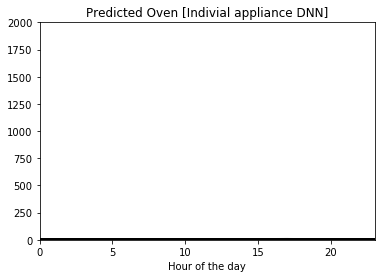

In [87]:
pd.DataFrame(pred_appliance['oven']).T.plot(legend=False, color='k',alpha=0.2)
plt.title("Predicted Oven [Indivial appliance DNN]")
plt.xlabel("Hour of the day")
plt.ylim((0, 2000))

In [24]:
pred_hvac.shape

(308, 24)

In [59]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




963.700018687
36.514444202


In [60]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     0.000061
1     0.000060
2     0.000058
3     0.000058
4     0.000079
5     0.000116
6     0.000062
7    -7.088656
8     0.000038
9     0.000054
10    0.000099
11    0.000114
12    0.000116
13    0.000116
14    0.000242
15    0.000233
16    0.000221
17    0.000226
18    0.000233
19    0.000233
20    0.000221
21    0.000099
22    0.000094
23    0.000115
dtype: float64

In [65]:
pred_appliance['hvac']

array([[  352.51669312,   340.69998169,   359.05001831, ...,
          334.5166626 ,   290.18334961,    43.63333511],
       [  307.41827393,    79.71666718,     0.        , ...,
          538.0166626 ,   184.31666565,   338.09088135],
       [   71.69999695,    86.25      ,   354.18331909, ...,
          539.9833374 ,   657.95001221,   390.2666626 ],
       ..., 
       [  889.60003662,   882.86669922,   487.75      , ...,
          808.75      ,   904.4666748 ,  1699.83776855],
       [ 1292.09997559,  1368.68334961,  1103.33337402, ...,
          852.31671143,  1971.55493164,  1216.26672363],
       [ 1143.51672363,  1097.15002441,   831.14996338, ...,
          941.18334961,  2303.64990234,  1493.20007324]], dtype=float32)

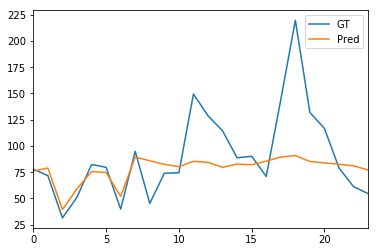

In [67]:
pd.Series(test_fridge[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(pred_appliance['fridge'][1]).plot(label='Pred')




plt.legend()